# Parameterized Post-Einsteinian Waveform Tutorial

GWCorrect v0.18.2

In this tutorial, we demonstrate the usage of the `GWCorrect.ppE` submodule of this python package. You can download this tutorial [here](https://github.com/RyanSR71/GWCorrect/blob/main/docs/source/notebooks/ppE_Tutorial.ipynb).

The following cell is everything we need to import to run this tutorial. We also import the `GWCorrect` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [2]:
import os
import numpy as np
import bilby
import matplotlib.pyplot as plt
import lal
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import requests
import GWCorrect
import GWCorrect.ppE as ppE

## ppE Correction Model

We will first demonstrate how to set up the ppE correction model. This process is very simple and only requires one modification to the default bilby waveform generator. `GWCorrect.ppE.waveform_generator.ppECorrectionModel` is a frequency domain source model, and can be placed into the bilby waveform generator as an argument.

In [3]:
waveform_arguments = dict(waveform_approximant='IMRPhenomD', reference_frequency=20, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

ppE_waveform_generator = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                    waveform_arguments=waveform_arguments,
                    # we simply place the ppE correction model as the frequency_domain_source_model 
                    frequency_domain_source_model=ppE.waveform_generator.ppECorrectionModel,
                    sampling_frequency=4096, 
                    duration=4,
                )

16:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: GWCorrect.ppE.waveform_generator.ppECorrectionModel
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


That is all we had to do to set up the ppE correction model! To use this model, we need to make sure to add the new source parameters that the model calls.

These new parameters are: $\tilde\beta$, $\delta\tilde\epsilon$, and $b$. To see what these parameters do, we can plot the frequency domain phase differences with various draws of the parameters. First, we start by defining a default bilby waveform generator to serve as our baseline waveform. We also choose some binary black hole injection parameters.

In [4]:
waveform_arguments = dict(waveform_approximant='IMRPhenomD', reference_frequency=20, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

GR_waveform_generator = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                    waveform_arguments=waveform_arguments,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                    sampling_frequency=4096, 
                    duration=4,
                )

# arbitrary binary black hole injection parameters
injection = dict(
    chirp_mass=20,
    mass_ratio=1,
    chi_1=0,
    chi_2=0,
    luminosity_distance=1000,
    geocent_time=1126259642.5,
    phase=1.577,
    theta_jn=0.48736165
)

16:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Now we can use `GWCorrect.wfu.parameterization.fd_model_difference` to help us find the phase differences created by the new parameters. First, we start with $\tilde\beta$. We fix $\delta\tilde\epsilon=0$ and $b=-1$.

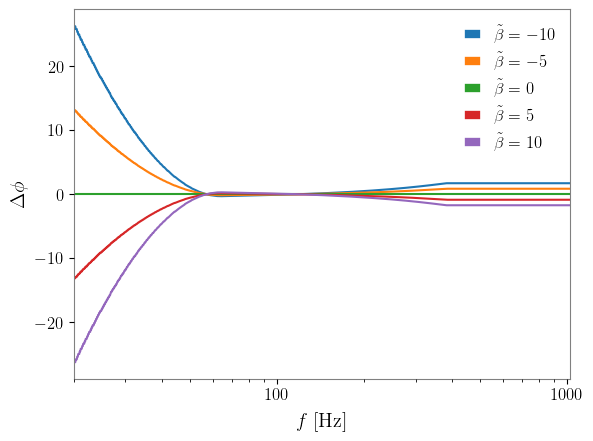

In [5]:
# adding the ppE parameters
injection['delta_epsilon_tilde'] = 0
injection['b'] = -1

# power spectral densities for aligned_phase_difference calculation
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

for beta_tilde in [-10,-5,0,5,10]:
    
    injection['beta_tilde'] = beta_tilde
    
    frequency_grid, _, phase_difference = GWCorrect.wfu.parameterization.fd_model_difference(ppE_waveform_generator,GR_waveform_generator,
                                                                                             injection=injection, psd_data=psd_data)
    
    plt.semilogx(frequency_grid,phase_difference,label=r'$\tilde\beta=val$'.replace('val',str(beta_tilde)))
    
    
plt.xlim(20,1024)
plt.grid(False)
plt.xlabel(r'$f\ [\mathrm{Hz}]$')
plt.ylabel(r'$\Delta\phi$')
plt.legend(frameon=False)
plt.show()

We see that $\tilde\beta$ controls the magnitude of the ppE correction, where higher values create larger deviations from GR ($\tilde\beta=0$) in the early inspiral.

We can do this same analysis with $\delta\tilde\epsilon$, but this time, fixing $\tilde\beta=0$.

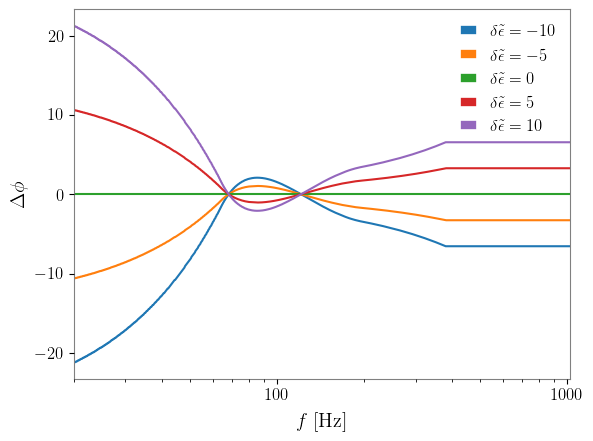

In [6]:
injection['beta_tilde'] = 0

# power spectral densities for aligned_phase_difference calculation
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

for delta_epsilon_tilde in [-10,-5,0,5,10]:
    
    injection['delta_epsilon_tilde'] = delta_epsilon_tilde
    
    frequency_grid, _, phase_difference = GWCorrect.wfu.parameterization.fd_model_difference(ppE_waveform_generator,GR_waveform_generator,
                                                                                             injection=injection, psd_data=psd_data)
    
    plt.semilogx(frequency_grid,phase_difference,label=r'$\delta\tilde\epsilon=val$'.replace('val',str(delta_epsilon_tilde)))
    
    
plt.xlim(20,1024)
plt.grid(False)
plt.xlabel(r'$f\ [\mathrm{Hz}]$')
plt.ylabel(r'$\Delta\phi$')
plt.legend(frameon=False)
plt.show()

$\delta\tilde\epsilon$ together with $\tilde\beta$ define another parameter, $\epsilon$, which controls the merger time of the gravitational wave. This introduces a shift in the time domain that we see as these curves in the frequency domain.

Finally, we look at how $b$ affects the phase. $b$ has no effect on the waveform if $\tilde\beta$ and $\delta\tilde\epsilon$ are 0, so we choose to set $\tilde\beta=1$ and $\delta\tilde\epsilon=0$.

Note: $b=0$ and $b=3$ are invalid values for $b$. Both of these cause overall shifts in either time or phase, which are undetectable in parameter estimation.

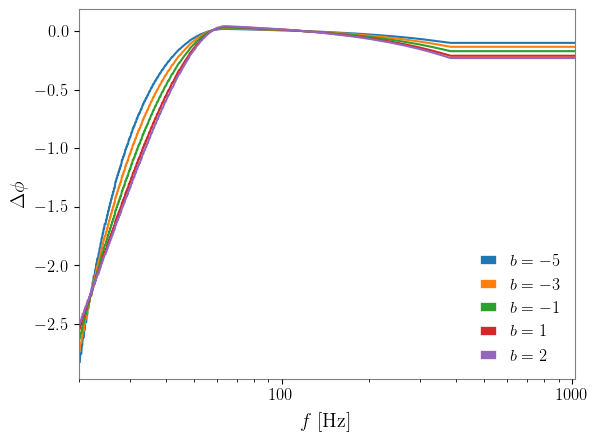

In [7]:
injection['beta_tilde'] = 1
injection['delta_epsilon_tilde'] = 0

# power spectral densities for aligned_phase_difference calculation
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

for b in [-5,-3,-1,1,2]:
    
    injection['b'] = b
    
    frequency_grid, _, phase_difference = GWCorrect.wfu.parameterization.fd_model_difference(ppE_waveform_generator,GR_waveform_generator,
                                                                                             injection=injection, psd_data=psd_data)
    
    plt.semilogx(frequency_grid,phase_difference,label=r'$b=val$'.replace('val',str(b)))
    
plt.xlim(20,1024)
plt.grid(False)
plt.xlabel(r'$f\ [\mathrm{Hz}]$')
plt.ylabel(r'$\Delta\phi$')
plt.legend(frameon=False)
plt.show()

$b$ controls the post-Newtonian (PN) order of the ppE correction. The PN order can be found with $(b+5)/2$.

## ppE.prior

In this section, we look at the `GWCorrect.ppE.prior` submodule, which contains the `match` and `match_plot` functions.

Using this package, we can also compute the normalized match between two waveforms. To demonstrate this, we look to calculate the match between a GR waveform and a ppE waveform with $\tilde\beta=1$, $\delta\tilde\epsilon=0$ and $b=-1$. We start by generating the two waveforms:

In [8]:
waveform_arguments = dict(waveform_approximant='IMRPhenomD', reference_frequency=20, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

ppE_waveform_generator = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                    waveform_arguments=waveform_arguments,
                    # we simply place the ppE correction model as the frequency_domain_source_model 
                    frequency_domain_source_model=ppE.waveform_generator.ppECorrectionModel,
                    sampling_frequency=4096, 
                    duration=4,
                )

GR_waveform_generator = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                    waveform_arguments=waveform_arguments,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                    sampling_frequency=4096, 
                    duration=4,
                )

injection = dict(
    chirp_mass=20,
    mass_ratio=1,
    chi_1=0,
    chi_2=0,
    luminosity_distance=1000,
    geocent_time=1126259642.5,
    phase=1.577,
    theta_jn=0.48736165
)

injection['beta_tilde'] = 1
injection['delta_epsilon_tilde'] = 0
injection['b'] = -1

GR_waveform = GR_waveform_generator.frequency_domain_strain(parameters=injection)['plus']
ppE_waveform = ppE_waveform_generator.frequency_domain_strain(parameters=injection)['plus']

match = ppE.prior.match(ppE_waveform,GR_waveform,4)
print(f'Match: {100*match}%')

Match: 63.13209146246588%


To see how the match changes with $\tilde\beta$ and $\delta\tilde\epsilon$, we can use `GWCorrect.ppE.prior.match_plot` to generate a contour plot:

Generating Contour Plot: 100%|██████████| 225/225 [00:35<00:00,  6.34it/s]


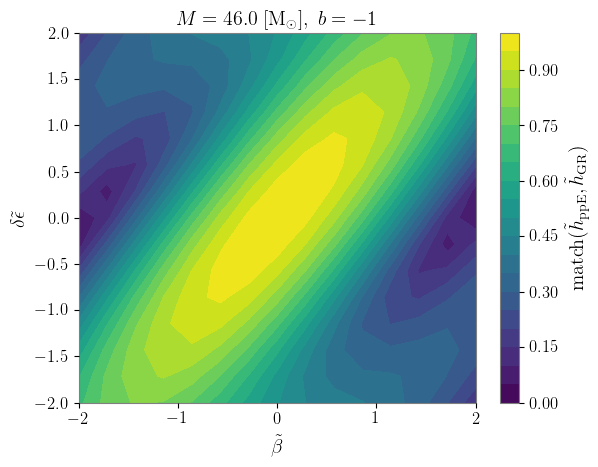

In [9]:
# choose a binary black hole injection
injection = dict(
    chirp_mass=20,
    mass_ratio=1,
    chi_1=0,
    chi_2=0,
    luminosity_distance=1000,
    geocent_time=1126259642.5,
    phase=1.577,
    theta_jn=0.48736165
)

# include a b value
injection['b'] = -1

# choose beta_tilde and delta_epsilon values to sample and put them in arrays
beta_tildes = np.linspace(-2,2,15)
delta_epsilon_tildes = np.linspace(-2,2,15)

# creating a directory for the tutorial files
try:
    os.mkdir('tutorial_files')
except:
    pass

# creating a contour plot and saving it to the tutorial files directory
ppE.prior.match_plot(ppE_waveform_generator,GR_waveform_generator,injection,beta_tildes,delta_epsilon_tildes,save=True,path='tutorial_files')

## Sampling and Posterior Analysis

To perform parameter estimation with the ppE waveform model, we simply need to add $\tilde\beta$, $\delta\tilde\epsilon$, and $b$ to a standard binary black hole prior. The following cell contains a typical ppE prior:

In [10]:
prior = bilby.core.prior.PriorDict()

prior['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass',latex_label=r'$\mathcal{M}_c$',minimum=5,maximum=50,unit=r'$\mathrm{M}_{\odot}$')
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$D_L$',minimum=50,maximum=1000,unit='Mpc')
prior['geocent_time'] = bilby.core.prior.Uniform(name='geocent_time',latex_label=r'$t_{c}$',minimum=1126259642.4,maximum=1126259642.6,unit='s')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\phi_\mathrm{ref}$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')

prior['beta_tilde'] = bilby.core.prior.Uniform(name='beta_tilde',latex_label=r'$\tilde{\beta}$',minimum=-2,maximum=2)
prior['delta_epsilon_tilde'] = bilby.core.prior.Uniform(name='delta_epsilon_tilde',latex_label=r'$\delta\tilde{\epsilon}$',minimum=-2,maximum=2)
prior['b'] = bilby.core.prior.Uniform(name='b',latex_label=r'$b$',minimum=-5,maximum=4)

# we hold the following parameters constant
prior['mass_ratio'] = bilby.core.prior.DeltaFunction(name='mass_ratio',peak=1)
prior['chi_1'] = bilby.core.prior.DeltaFunction(name='chi_1',peak=0)
prior['chi_2'] = bilby.core.prior.DeltaFunction(name='chi_2',peak=0)

Parameter estimation can then be performed normally. See [bilby's documentation](https://bilby-dev.github.io/bilby/visualising_the_results.html) for details.

The resulting posterior file will contain the posteriors for $\tilde\beta$, $\delta\tilde\epsilon$, and $b$. We can load in an example result file to examine it:

In [11]:
# downloading the file and saving to tutorial files folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/GWCorrect/raw/refs/heads/main/files/ppE_sample_result_v0.18.2.1_result.json', allow_redirects=True)
open("tutorial_files/ppE_sample_result_v0.18.2.1_result.json", 'wb').write(file.content)

# loading the file
result = bilby.read_in_result("tutorial_files/ppE_sample_result_v0.18.2.1_result.json")

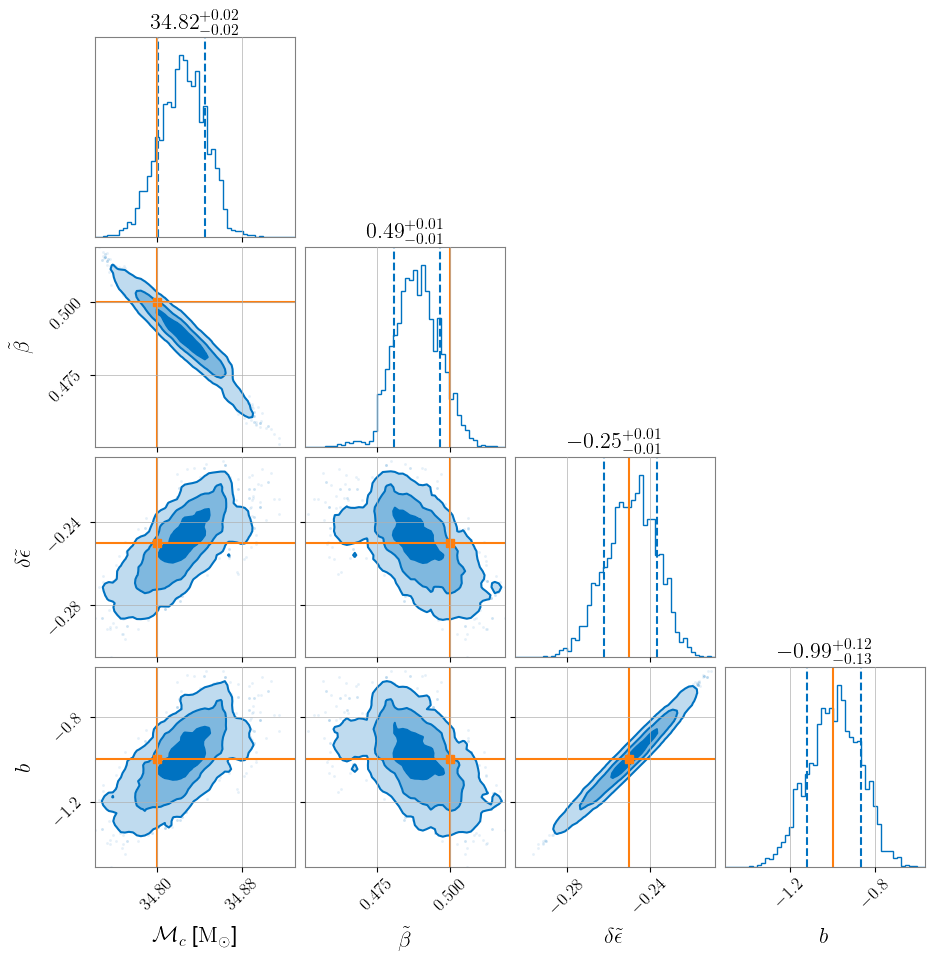

In [12]:
injection = dict(
    chirp_mass = 34.8,
    beta_tilde = 0.50,
    delta_epsilon_tilde = -0.25,
    b = -1
)

result.plot_corner(save=False,truth=injection)
plt.show()